# Data exploration

In [81]:
import pandas as pd
import numpy as np
import re
import math
import requests
import json
import matplotlib
from pandas import ExcelFile
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import plotly.express
import reverse_geocoder as rg
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scicolorscales import *

In [109]:
df = pd.read_json("storms.json")

In [110]:
df

,id,title,categories,date,closed,geometries,coordinates,location,admin,ISO2,ISO3,Country
0,EONET_4615,Tropical Cyclone Herold,Severe Storms,2020-03-13,NaN,"{'type': 'Point', 'coordinates': [-14.3, 52.4]}","[-14.3, 52.4]",Antalaha,Sava,MG,MDG,Madagascar
1,EONET_4616,Tropical Cyclone Gretel,Severe Storms,2020-03-13,NaN,"{'type': 'Point', 'coordinates': [-16.9, 153.8]}","[-16.9, 153.8]",Proserpine,Queensland,AU,AUS,Australia
2,EONET_4612,Tropical Cyclone 21S,Severe Storms,2020-03-11,1.584317e+12,"{'type': 'Point', 'coordinates': [-16.4, 116.9]}","[-16.4, 116.9]",Dampier,Western Australia,AU,AUS,Australia
3,EONET_4596,Tropical Cyclone Ferdinand,Severe Storms,2020-02-23,1.583366e+12,"{'type': 'Point', 'coordinates': [-13.4, 118.7]}","[-13.4, 118.7]",Lailunggi,East Nusa Tenggara,ID,IDN,Indonesia
4,EONET_4595,Tropical Cyclone Esther,Severe Storms,2020-02-23,1.583280e+12,"{'type': 'Point', 'coordinates': [-15.6, 139.5]}","[-15.6, 139.5]",Alyangula,Northern Territory,AU,AUS,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...
1814,EONET_2351,Typhoon #34,Severe Storms,2000-01-01,9.786528e+11,"{'type': 'Point', 'coordinates': [14.7, 131.6]}","[14.7, 131.6]",San Policarpo,Eastern Visayas,PH,PHL,Philippines (the)
1815,EONET_2312,Cyclone #4,Severe Storms,2000-01-01,9.786528e+11,"{'type': 'Point', 'coordinates': [-10.2, 65.4]}","[-10.2, 65.4]",Cargados Carajos,Cargados Carajos,MU,MUS,Mauritius
1816,EONET_2409,Cyclone #2,Severe Storms,1999-12-10,9.456480e+11,"{'type': 'Point', 'coordinates': [-13.3, 119.4]}","[-13.3, 119.4]",Lailunggi,East Nusa Tenggara,ID,IDN,Indonesia
1817,EONET_2410,Tropical Storm #1,Severe Storms,1999-12-10,9.458208e+11,"{'type': 'Point', 'coordinates': [-9.4, 97.4]}","[-9.4, 97.4]",West Island,,CC,CCK,Cocos (Keeling) Islands (the)


In [111]:
df.drop(columns = "closed", inplace = True)

In [112]:
df = df.assign(year_month=df["date"].dt.to_period("M"))

In [113]:
cyclone_year = (df
                .groupby(["year_month"])[["id"]]
                .count()
                .reset_index()
                .rename(columns = {"id": "no_cyclones"}))

In [114]:
cyclone_year["year_month"] = pd.to_datetime(cyclone_year["year_month"].astype(str))

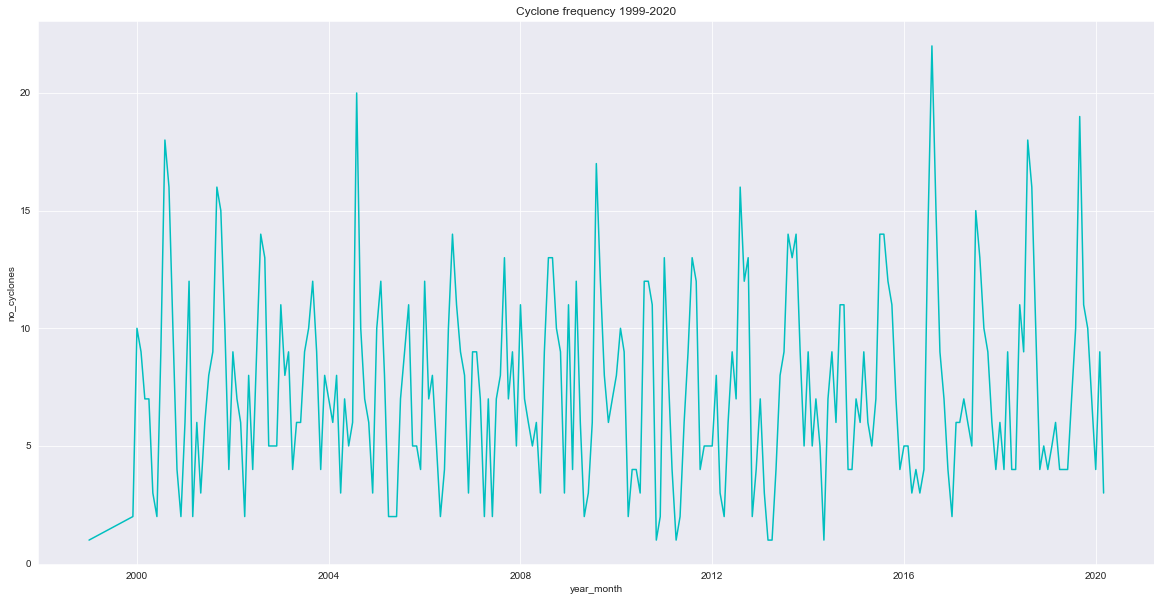

In [115]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
g = sns.lineplot(data=cyclone_year,
             x="year_month",
             y="no_cyclones",
             color = "c");
plt.title("Cyclone frequency 1999-2020");

In [116]:
df["year"]= df["date"].dt.year

df_country = (df
              .groupby(["year", "Country", "ISO3"])[["id"]]
              .count()
              .reset_index()
              .rename(columns= {"id": "Number of Cyclones"}))

In [117]:
df["dummy"] = 1

In [118]:
ds = df.copy()
ds.sort_values("year", inplace= True)

In [119]:
ds["cumsum"] = ds.groupby(["Country", "ISO3"])[['dummy']].transform(pd.Series.cumsum)

In [120]:
cycl_country = (ds
                .groupby(["year", "Country", "ISO3"])[["cumsum"]]
                .max()
                .reset_index()
                .rename(columns= {"cumsum": "Number of Cyclones"}))

In [121]:
cycl_country

,year,Country,ISO3,Number of Cyclones
0,1999,Cocos (Keeling) Islands (the),CCK,1
1,1999,Indonesia,IDN,1
2,1999,Madagascar,MDG,1
3,2000,Australia,AUS,5
4,2000,Bahamas (the),BHS,1
...,...,...,...,...
666,2020,Madagascar,MDG,29
667,2020,Mauritius,MUS,64
668,2020,Samoa,WSM,3
669,2020,Vanuatu,VUT,32


In [122]:
fig= px.choropleth(cycl_country, 
                   locations="ISO3", 
                   color="Number of Cyclones", 
                   hover_name="Country",
                   animation_frame="year",
                   animation_group="ISO3",
                   projection="robinson",
                   color_continuous_scale = oslorev
                   )
                

fig.update_layout(
    title_text = 'Number of cyclones per Country and year (cummulative)'
    #marker_line_color='white'# Create a Title
    #geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show() 


In [123]:
cycl_c = (cycl_country
          .groupby(["Country", "ISO3"])[["Number of Cyclones"]]
          .max()
          .reset_index())

In [124]:
cycl_c.head()

,Country,ISO3,Number of Cyclones
0,American Samoa,ASM,15
1,Anguilla,AIA,3
2,Antigua and Barbuda,ATG,5
3,Aruba,ABW,1
4,Australia,AUS,109


In [125]:
fig= px.choropleth(cycl_c, 
                   locations="ISO3", 
                   color="Number of Cyclones", 
                   hover_name="Country",
                   projection="robinson",
                   color_continuous_scale = px.colors.sequential.Inferno[::-1]
                   )
                

fig.update_layout(
    title_text = 'Number of cyclones per Country (1999-2020)'
    #marker_line_color='white'# Create a Title
    #geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show() 


We can see that the most vulnerable region to Cyclones is Australia. However, many countries in South Asia and Pacific Islands show also vulnerability at this regard.  